In [1]:
import ast
from datetime import datetime
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

In [2]:
pd.set_option('display.max_columns', None)

Schema for columns in dataset

schema: https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=150111846

In [3]:
# Load Seattle calender, listings, and reviews data
s_cale = pd.read_csv("./Seattle/calendar.csv")
s_list = pd.read_csv("./Seattle/listings.csv")
s_revi = pd.read_csv("./Seattle/reviews.csv")

In [4]:
s_list_columns = s_list.columns
len(s_list.columns)

92

In [5]:
# Get the first and last day of the Seattle calendar dataset
s_date_min = s_cale["date"].min()
s_date_max = s_cale["date"].max()
print(f"""
          Seattle Max : {s_date_min}
                  Min : {s_date_max}""")


          Seattle Max : 2016-01-04
                  Min : 2017-01-02


In [6]:
# Get min/max for each listing within the Seattle dataset.   
min_dates = s_cale.groupby("listing_id")["date"].min()
max_dates = s_cale.groupby("listing_id")["date"].max()

print(max_dates.value_counts())
print(min_dates.value_counts())

2017-01-02    3818
Name: date, dtype: int64
2016-01-04    3818
Name: date, dtype: int64


In [7]:
# Function to get day of the week
int_to_day = {
    0:"Monday",
    1:"Tuesday",
    2:"Wednesday",
    3:"Thursday",
    4:"Friday",
    5:"Saturday",
    6:"Sunday"
}
def get_day_of_week(in_date:[str, datetime], 
                    return_type:[int, str] = str,
                    int_weekday_map:dict = int_to_day):
    """
    This function takes in a date, either a string or datetime object,
    and returns the day of the week for that date.
    
    In values:
        in_date:[str, datetime]
        return_type:[int, str] = str
        int_weekday_map:dict = int_to_day
        
    
        In strings must be in the format YYYY-MM-DD.
        
    Out values:
        int - number 0-6 that represents Monday to Sunday
        str - weekday
    
    """
    if type(in_date) == str:
        in_date = datetime.strptime(in_date, "%Y-%m-%d")
    elif type(in_date) == datetime:
        pass
    out_day_of_the_week = in_date.weekday()
    if return_type == int:
        return out_day_of_the_week
    elif return_type == str:
        return int_to_day[out_day_of_the_week]

In [8]:
# Test string in, string out
get_day_of_week("2016-01-05", return_type = str)

'Tuesday'

In [9]:
# Test datetime object in, int out
get_day_of_week(datetime.now(), return_type = int)

6

In [10]:
# Set federal holidays
fed_hol = {
    "2016-01-18":"Martin Luther King Day",
    "2016-02-15":"Presidents Day",
    "2016-05-30":"Memorial Day",
    "2016-07-04":"Independence Day",
    "2016-09-05":"Labor Day",
    "2016-10-10":"Columbus Day",
    "2016-11-11":"Veterans Day",
    "2016-11-24":"Thanksgiving",
    "2016-11-25":"Thanksgiving observed",
    "2016-12-25":"Christmas Day",
    "2016-12-26":"Christmas Day observed",
    "2017-01-01":"New Years Day"
}

In [11]:
# See which weekday federal holays fell on in 2016
for date in fed_hol.keys():
    print(get_day_of_week(date))

Monday
Monday
Monday
Monday
Monday
Monday
Friday
Thursday
Friday
Sunday
Monday
Sunday


In [12]:
# Set fed holidays with their corresponding weekend
fed_hols = {
    "2016-01-16":"Martin Luther King Day sat",
    "2016-01-17":"Martin Luther King Day sun",
    "2016-01-18":"Martin Luther King Day",
    "2016-02-13":"Presidents Day sat",
    "2016-02-14":"Presidents Day sun",
    "2016-02-15":"Presidents Day",
    "2016-05-28":"Memorial Day sat",
    "2016-05-29":"Memorial Day sun",
    "2016-05-30":"Memorial Day",
    "2016-07-02":"Independence Day sat",
    "2016-07-03":"Independence Day sun",
    "2016-07-04":"Independence Day",
    "2016-09-03":"Labor Day sat",
    "2016-09-04":"Labor Day sun",
    "2016-09-05":"Labor Day",
    "2016-10-08":"Columbus Day sat",
    "2016-10-09":"Columbus Day sun",
    "2016-10-10":"Columbus Day",
    "2016-11-11":"Veterans Day",
    "2016-11-12":"Veterans Day sat",
    "2016-11-13":"Veterans Day sun",
    "2016-11-24":"Thanksgiving",
    "2016-11-25":"Thanksgiving observed",
    "2016-11-26":"Thanksgiving sat",
    "2016-11-27":"Thanksgiving sun",
    "2016-12-23":"Christmas Day sat",
    "2016-12-24":"Christmas Day sun",
    "2016-12-25":"Christmas Day",
    "2016-12-26":"Christmas Day observed",
    "2016-12-31":"New Years Day sat",
    "2017-01-01":"New Years Day",
    "2017-01-02":"New Years Day mon",
}

In [13]:
# Create columns for each holiday for the Seattle List dataset
for date, holiday in fed_hol.items():
    s_list[holiday] = False

In [14]:
# Identify if a listing was available on a holiday
cales = [s_cale]
lists = [s_list]
for i in range(len(cales)):
    cale = cales[i]
    _list = lists[i]
    for listing_id in tqdm(cale["listing_id"].unique()):
        cale_ss_mask_id = cale["listing_id"]==listing_id
        # Create subsection of the index per listing ID
        ss_cale = cale[cale_ss_mask_id]
        for holiday_date, holiday in fed_hol.items():
            # Get index of the holiday date per index ID
            ss_cale_index_date = ss_cale[ss_cale["date"]==holiday_date].index
            if len(ss_cale_index_date) > 0:
                holiday_availability = cale.iloc[ss_cale_index_date]["available"]
                if str(holiday_availability.iloc[0]) == "t":
                    _list_ss_index = _list[_list["id"] == listing_id].index
                    # Note: Docs state reassigning values using 
                    # loc[index, column] is the most reliable
                    _list.loc[_list_ss_index, holiday] = True
                elif str(holiday_availability.iloc[0]) == "f":
                    continue

100%|██████████████████████████████████████████████████████████████████████████████| 3818/3818 [02:44<00:00, 23.26it/s]


In [15]:
# Generate a list of the federal holidays
# View portion of the mapping created for the Seattle List dataset
list_fed_hols = [v for k, v in fed_hol.items()]
s_list["all_holidays"] = s_list[list_fed_hols].sum(1)
s_list[list_fed_hols + ["all_holidays"]]

,Martin Luther King Day,Presidents Day,Memorial Day,Independence Day,Labor Day,Columbus Day,Veterans Day,Thanksgiving,Thanksgiving observed,Christmas Day,Christmas Day observed,New Years Day,all_holidays
0,True,True,True,True,True,True,True,True,True,True,True,True,12
1,True,False,True,True,True,True,True,True,True,True,True,True,11
2,False,True,False,True,True,True,True,True,True,True,True,True,10
3,False,False,False,False,True,True,True,True,True,True,True,True,8
4,True,True,True,True,True,True,True,True,True,True,True,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,True,False,False,False,False,False,False,False,False,False,False,False,1
3814,False,False,True,True,True,True,True,True,True,True,True,True,10
3815,True,True,False,False,False,False,False,False,False,False,False,False,2
3816,True,True,True,False,False,False,False,False,False,False,False,False,3


In [16]:
# simple function to create histogram of values found
# in a column and percentage each value occupied
def value_count_hist(df:pd.DataFrame,
                     column:str,
                     title:str):
    """
    This function returns a simple histogram showing the
    distribution of values in a column.
    
    In values:
        df - a pd.DataFrame
        column - a column in df
        title - a title for the graph
        
    Out values:
        a graph
    """
    vals = df[column].value_counts()
    (vals/s_list.shape[0]).plot(kind="bar")
    plt.title(title)

Question 1: What percentage of listings make a number of holidays available?

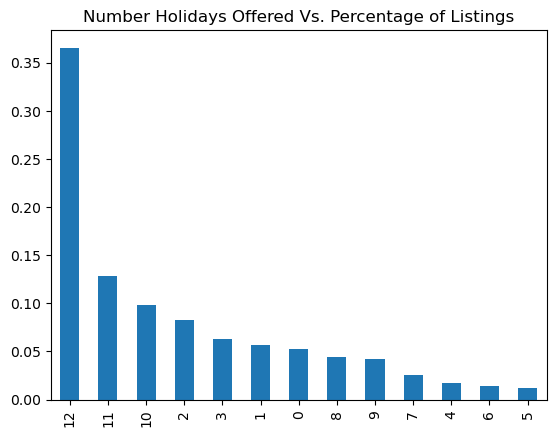

In [17]:
# see percentage for each value in "all_holidays" column. 
# Looks like most listings are available on holidays, with 
# the majority making all holidays available.
value_count_hist(s_list, "all_holidays", "Number Holidays Offered Vs. Percentage of Listings")

In [18]:
def column_percentage_True(df:pd.DataFrame,
                           columns:list,
                           title:str):
    """
    This function returns a histogram of the percentages
    of Trues in a column.
    
    In values:
        df:ps.Dataframe 
        columns:list
        title:str
        
    Out values:
        a graph
        the average True across all columns
    """
    vals = {"columns":[],
            "frequency":[]}
    for holiday in columns:
        available_sum = df[holiday].sum()
        vals["columns"].append(holiday)
        vals["frequency"].append(available_sum)

    vals = pd.DataFrame(vals, columns=['columns', 'frequency'])
    vals.index = vals["columns"]
    vals = vals.drop(["columns"], axis = 1)

    (vals/df.shape[0]).plot(kind="bar");
    plt.title(title);
    print(vals["frequency"].sum()/(df.shape[0]*vals.shape[0]))

Question 2: What percentage of holidays are available, sorted by date?

0.6919635061987078


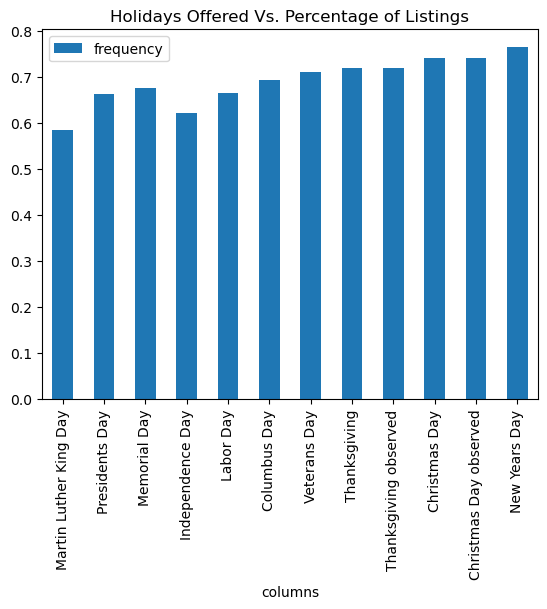

In [19]:
column_percentage_True(s_list, list_fed_hols, "Holidays Offered Vs. Percentage of Listings")

In [20]:
# Set holiday ranges (Holiday + it's corresponding weekend)
holiday_ranges = {
    "Martin Luther King Day all":"2016-01-16 2016-01-18",
    "Presidents Day all": "2016-02-13 2016-02-15",
    "Memorial Day all":"2016-05-28 2016-05-30",
    "Independence Day all":"2016-07-02 2016-07-04",
    "Labor Day all":"2016-09-03 2016-09-05",
    "Columbus Day all":"2016-10-08 2016-10-10",
    "Veterans Day all":"2016-11-11 2016-11-13",
    "Thanksgiving all":"2016-11-24 2016-11-27",
    "Christmas Day all":"2016-12-23 2016-12-26",
    "New Years Day all":"2016-12-31 2017-01-01",
}

In [21]:
# Create a datetime column from the date column
cales = [s_cale]
for cale in cales:
    cale["datetime"] = pd.to_datetime(cale['date'], format="%Y-%m-%d")

In [22]:
# Create columns for the holiday ranges
lists = [s_list]
for _list in lists:
    for holiday in holiday_ranges.keys():
        _list[holiday] = False

In [23]:
# Set values in the holiday range columns to true per listing
# if the entire range is available for the listing
cales = [s_cale]
lists = [s_list]
for i in range(len(cales)):
    cale = cales[i]
    _list = lists[i]
    for listing_id in tqdm(cale["listing_id"].unique()):
        cale_ss_mask_id = cale["listing_id"]==listing_id
        ss_cale = cale[cale_ss_mask_id]
        for holiday, holiday_range in holiday_ranges.items():
            range_low, range_high = holiday_range.split(" ")
            range_mask_low = ss_cale["datetime"] >= range_low
            range_mask_high = ss_cale["datetime"] <= range_high
            range_mask = range_mask_low*range_mask_high
            values = ss_cale[range_mask]["available"].value_counts().index
            if (len(values == 1) and (values[0] == "t")):
                ss_list_index = _list[_list["id"] == listing_id].index
                
                _list.loc[ss_list_index, holiday] = True
            

100%|██████████████████████████████████████████████████████████████████████████████| 3818/3818 [03:38<00:00, 17.46it/s]


In [24]:
# Create list of holiday range columns
# veiw results of mapping holidat ranges to listing IDs
list_fed_hol_ranges = [k for k in holiday_ranges.keys()]
print(len(list_fed_hol_ranges))
print(list_fed_hol_ranges)
s_list["all_holiday_ranges"] = s_list[list_fed_hol_ranges].sum(1)
s_list[list_fed_hol_ranges + ["all_holiday_ranges"]]

10
['Martin Luther King Day all', 'Presidents Day all', 'Memorial Day all', 'Independence Day all', 'Labor Day all', 'Columbus Day all', 'Veterans Day all', 'Thanksgiving all', 'Christmas Day all', 'New Years Day all']


,Martin Luther King Day all,Presidents Day all,Memorial Day all,Independence Day all,Labor Day all,Columbus Day all,Veterans Day all,Thanksgiving all,Christmas Day all,New Years Day all,all_holiday_ranges
0,False,True,True,True,True,True,True,True,True,True,9
1,False,False,True,True,True,True,True,True,True,True,8
2,False,True,False,True,True,True,True,True,True,True,8
3,False,False,False,False,True,True,True,True,True,True,6
4,True,True,True,True,True,True,True,True,True,True,10
...,...,...,...,...,...,...,...,...,...,...,...
3813,True,False,False,False,False,False,False,False,False,False,1
3814,False,False,True,True,True,True,True,True,True,True,8
3815,True,True,False,False,False,False,False,False,False,False,2
3816,True,True,True,False,False,False,False,False,False,False,3


Question 3: What percentage of listings make a number of holiday ranges available?

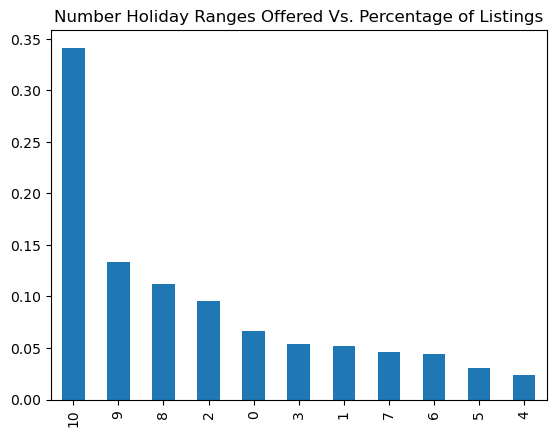

In [25]:
value_count_hist(s_list, "all_holiday_ranges", "Number Holiday Ranges Offered Vs. Percentage of Listings")

Question 2: What percentage of holiday ranges are available, sorted by date?

0.675615505500262


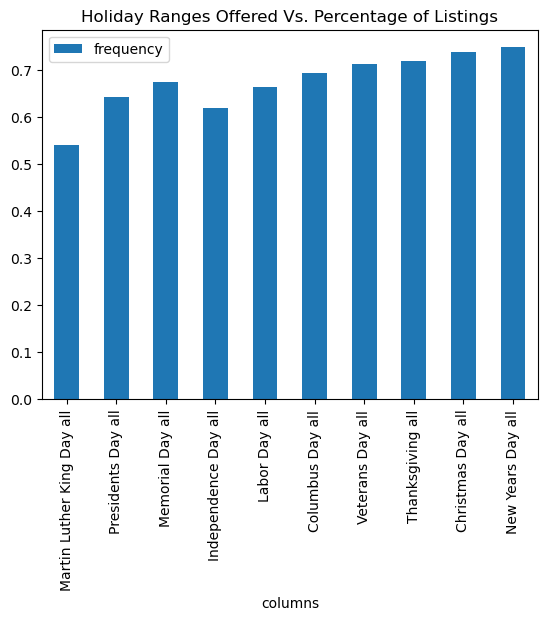

In [26]:
column_percentage_True(s_list, list_fed_hol_ranges, "Holiday Ranges Offered Vs. Percentage of Listings")

In [27]:
# View first_review values
s_list[~s_list["first_review"].isna()]["first_review"]

0       2011-11-01
1       2013-08-19
2       2014-07-30
4       2012-07-10
5       2015-06-11
           ...    
3810    2015-10-01
3811    2015-10-01
3812    2014-07-08
3813    2015-09-27
3814    2015-12-18
Name: first_review, Length: 3191, dtype: object

In [28]:
# Format first_review_date to datetime format
lists = [s_list]
for _list in lists:
    _list["first_review_datetime"] = pd.to_datetime(_list['first_review'], format="%Y-%m-%d")

In [29]:
# View size of Seattle list
s_list.shape[0]

3818

In [30]:
yearlong_s_list = s_list[s_list["first_review_datetime"] < "2016-01-04"]

In [31]:
# View size of Seattle list with a first_Review value higher than
yearlong_s_list.shape[0]

3191

Question 1-4 above, filtered by listings with a review from before the start of 2016.

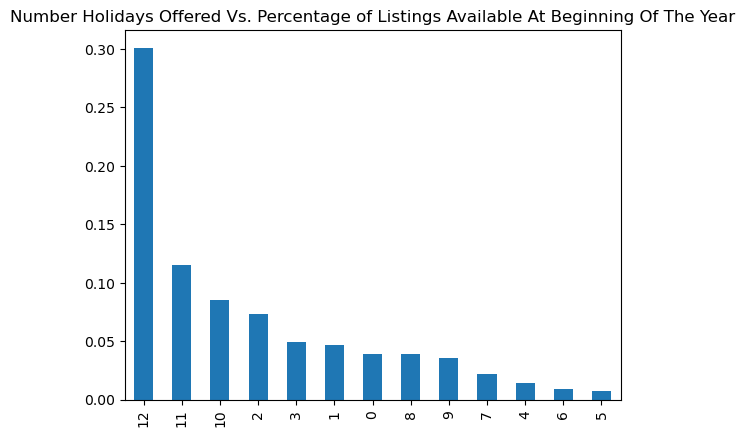

In [32]:
value_count_hist(yearlong_s_list, "all_holidays", "Number Holidays Offered Vs. Percentage of Listings Available At Beginning Of The Year")

0.6982137261046694


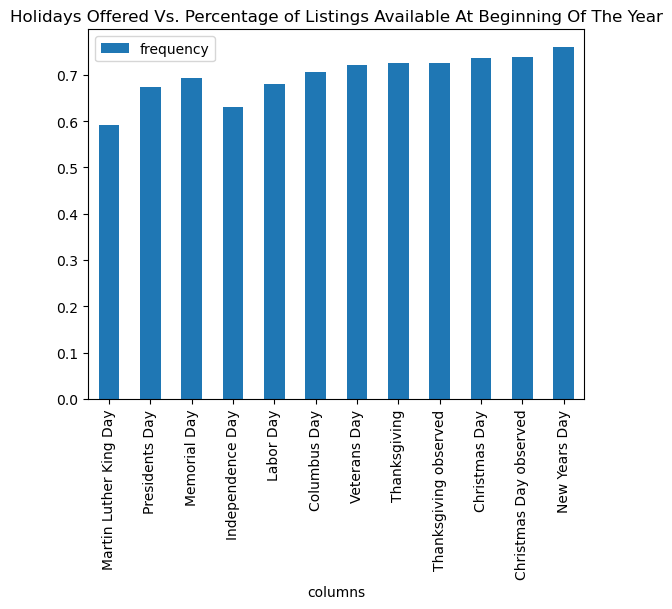

In [33]:
column_percentage_True(yearlong_s_list, list_fed_hols, "Holidays Offered Vs. Percentage of Listings Available At Beginning Of The Year")

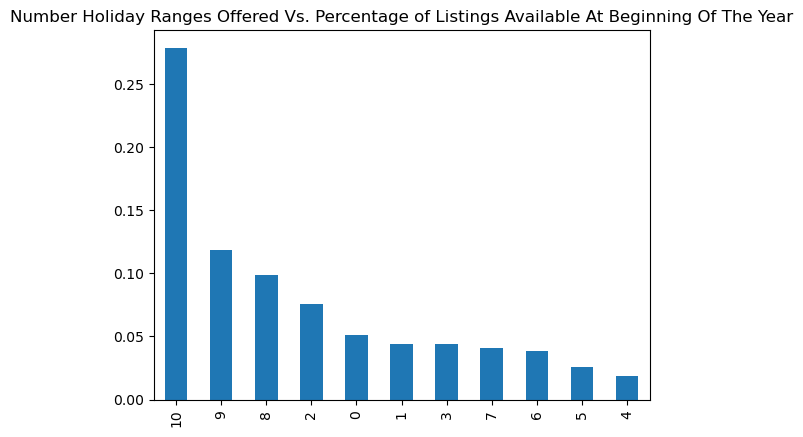

In [34]:
value_count_hist(yearlong_s_list, "all_holiday_ranges", "Number Holiday Ranges Offered Vs. Percentage of Listings Available At Beginning Of The Year")

0.6820745847696646


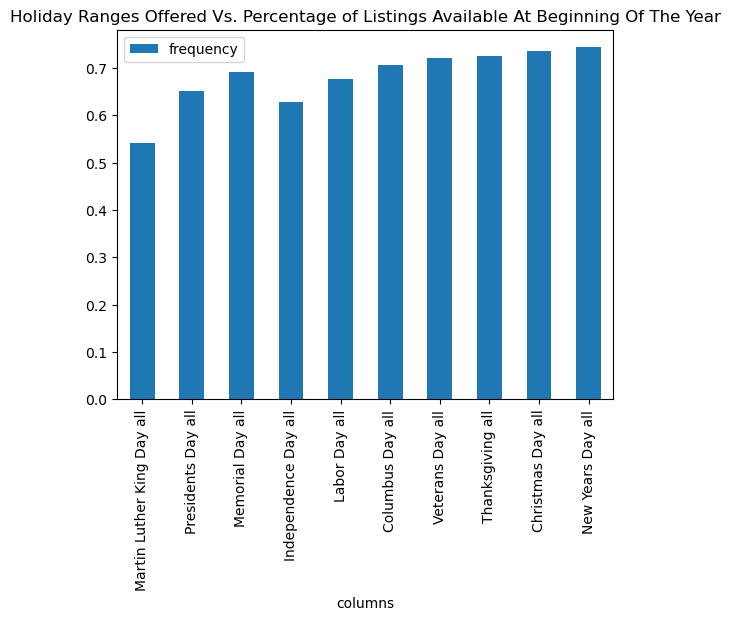

In [35]:
column_percentage_True(yearlong_s_list, list_fed_hol_ranges, "Holiday Ranges Offered Vs. Percentage of Listings Available At Beginning Of The Year")

In [36]:
# View the format of the amentities column
s_list["amenities"].value_counts()

{}                                                                                                                                                                                                                                                                                                                                                                                         45
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                                                                                                     11
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Essentia

In [37]:
# View different amentities offered
amenities = set()
for _list in lists:
    for i in _list.index:
        value = _list.loc[i, "amenities"]
        value = re.sub('"?,"?', ',', value)
        value = re.sub('"', '', value)
        value = re.sub(',', '","', value)
        value = value[0] + '"' + value[1:-1] + '"' + value[-1]
        value = ast.literal_eval(value)
        amenities.update(value)
amenities = [amenity for amenity in amenities if len(amenity) > 0]
print(amenities)

['Wireless Internet', 'Pool', 'Air Conditioning', 'Suitable for Events', 'Smoke Detector', 'Breakfast', 'Indoor Fireplace', 'Heating', 'TV', 'Washer', 'Carbon Monoxide Detector', '24-Hour Check-in', 'Hot Tub', 'Fire Extinguisher', 'Other pet(s)', 'First Aid Kit', 'Shampoo', 'Pets live on this property', 'Lock on Bedroom Door', 'Gym', 'Buzzer/Wireless Intercom', 'Hair Dryer', 'Dog(s)', 'Pets Allowed', 'Iron', 'Safety Card', 'Kitchen', 'Elevator in Building', 'Washer / Dryer', 'Smoking Allowed', 'Hangers', 'Essentials', 'Free Parking on Premises', 'Cat(s)', 'Laptop Friendly Workspace', 'Internet', 'Wheelchair Accessible', 'Dryer', 'Cable TV', 'Family/Kid Friendly', 'Doorman']


In [38]:
# Create a column for each amentiy found in the dataset
for _list in lists:
    for amentiy in amenities:
        _list["amenity_" + amentiy] = False

In [39]:
# Set value to True per amentity per listing ID if available
for _list in lists:
    for i in _list.index:
        amenities = _list.loc[i, "amenities"]
        amenities = re.sub('"?,"?', ',', str(amenities))
        amenities = re.sub('"', '', amenities)
        amenities = re.sub(',', '","', amenities)
        amenities = amenities[0] + '"' + amenities[1:-1] + '"' + amenities[-1]
        amenities = ast.literal_eval(amenities)
        for amenity in amenities:
            _list.loc[i, "amenity_"+amenity] = True

In [40]:
for column in s_list_columns:
    print(column)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
calendar_last_scraped
number_of_re

In [41]:
# # Set columns to predict availability off of
# prediction_columns = [
# "host_neighbourhood",
# "street",
# "neighbourhood",
# "neighbourhood_cleansed",
# "neighbourhood_group_cleansed",
# "zipcode",
# "property_type",
# "room_type",
# "accommodates",
# "bathrooms",
# "bedrooms",
# "beds",
# "bed_type",
# "square_feet",
# "price",
# "weekly_price",
# "monthly_price",
# "security_deposit",
# "cleaning_fee",
# "guests_included",
# "extra_people",
# "minimum_nights",
# "maximum_nights",
# "availability_30",
# "availability_60",
# "availability_90",
# "availability_365",
# "number_of_reviews",
# "review_scores_rating",
# "review_scores_accuracy",
# "review_scores_cleanliness",
# "review_scores_checkin",
# "review_scores_communication",
# "review_scores_location",
# "review_scores_value",
# "instant_bookable",
# "require_guest_profile_picture",
# "require_guest_phone_verification",
# ]

# for column in s_list.columns:
#     if "amenity_" in column:
#         prediction_columns.append(column)

In [42]:
prediction_columns = [
"host_neighbourhood",
"street",
"neighbourhood",
"neighbourhood_cleansed",
"neighbourhood_group_cleansed",
"zipcode",
"property_type",
"room_type",
"accommodates",
"bathrooms",
"bedrooms",
"beds",
"bed_type",
"square_feet",
"price",
"weekly_price",
"monthly_price",
"security_deposit",
"cleaning_fee",
"guests_included",
"extra_people",
"minimum_nights",
"maximum_nights",
"availability_30",
"availability_60",
"availability_90",
"availability_365",
"number_of_reviews",
"review_scores_rating",
"review_scores_accuracy",
"review_scores_cleanliness",
"review_scores_checkin",
"review_scores_communication",
"review_scores_location",
"review_scores_value",
"instant_bookable",
"require_guest_profile_picture",
"require_guest_phone_verification",
"host_location",
"host_response_time",
"host_response_rate",
"host_acceptance_rate",
"host_is_superhost",
"host_listings_count",
"host_total_listings_count",
"host_verifications",
"host_has_profile_pic",
"host_identity_verified"
]
for column in s_list.columns:
    if "amenity_" in column:
        prediction_columns.append(column)

In [43]:
# Drop columns that contain too many NaN values
for _list in lists:
    for column in prediction_columns:
        sum_na = _list[column].isna().sum()
        percentge_na = sum_na/len(_list)
        if percentge_na >= .95:
            print("drop: " + column)
            prediction_columns.remove(column)

drop: square_feet
drop: amenity_


In [44]:
# View column, dtype, and number values missing
for column  in prediction_columns:
    x = s_list[column].isna().sum()
    dtype = s_list[column].dtype
    column = column+"                              "
    dtype = str(dtype)+"                           "
    print(column[:30], dtype[:10], x)

host_neighbourhood             object     300
street                         object     0
neighbourhood                  object     416
neighbourhood_cleansed         object     0
neighbourhood_group_cleansed   object     0
zipcode                        object     7
property_type                  object     1
room_type                      object     0
accommodates                   int64      0
bathrooms                      float64    16
bedrooms                       float64    6
beds                           float64    1
bed_type                       object     0
price                          object     0
weekly_price                   object     1809
monthly_price                  object     2301
security_deposit               object     1952
cleaning_fee                   object     1030
guests_included                int64      0
extra_people                   object     0
minimum_nights                 int64      0
maximum_nights                 int64      0
availability_30

In [45]:
# Clean True/False values to contain True/False values, no t/f
obj_to_bool_columns = [
    "instant_bookable",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
]
tf_dict = {
    "t":True,
    "f":False,
    False:False,
    True:True
}
for _list in lists:
    for column in obj_to_bool_columns:
        _list[column] = _list[column].apply(lambda x: tf_dict[x])

In [46]:
s_list["require_guest_profile_picture"]

0       False
1        True
2       False
3       False
4       False
        ...  
3813    False
3814    False
3815    False
3816    False
3817    False
Name: require_guest_profile_picture, Length: 3818, dtype: bool

In [47]:
# Clean dollar value columns to be a float
obj_to_int_columns = [
"extra_people",
"price",
"weekly_price",
"monthly_price",
"security_deposit",
"cleaning_fee"
]
for _list in lists:
    for column in obj_to_int_columns:
        _list[column] = _list[column].replace('[\$,]', '', regex=True).astype(float)

In [48]:
s_list["cleaning_fee"]

0         NaN
1        40.0
2       300.0
3         NaN
4       125.0
        ...  
3813    230.0
3814     50.0
3815     35.0
3816     45.0
3817      NaN
Name: cleaning_fee, Length: 3818, dtype: float64

In [49]:
# Create dataframe that will contain x values
# This is so that substituted values input belwo do not 
# have the chance to modify the y values
clean_s_list = s_list[prediction_columns]

In [50]:
# Fill missing float, int values with the mean for teh column
num_vars = clean_s_list.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    clean_s_list[col].fillna((clean_s_list[col].mean()), inplace=True)

C:\Users\Swan\AppData\Local\Temp\ipykernel_11844\4024449742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_s_list[col].fillna((clean_s_list[col].mean()), inplace=True)


In [51]:
# Turn each object column into multiple columns representing
# values available in the original column
cat_vars = clean_s_list.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    clean_s_list = pd.concat([clean_s_list.drop(var, axis=1), pd.get_dummies(clean_s_list[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [52]:
# View that there are no empty values
for column in clean_s_list.columns:
    x = clean_s_list[column].isna().sum()
    if x:
        print(column)

Question 5: Finding the best model to predict availability. 

In [53]:
# View prediction ability per holiday with all X columns available
# Last line is average rsquared sum
rsquareds = []
for holiday in list_fed_hols:
    X = clean_s_list
    y = s_list[holiday]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 
    y_test_preds = lm_model.predict(X_test) 
    rsquared_score = r2_score(y_test, y_test_preds)
    print(holiday, rsquared_score)
    rsquareds.append(rsquared_score)
print("average: " + str(sum(rsquareds)/len(list_fed_hols)))

Martin Luther King Day 0.4399584321615011
Presidents Day 0.6749737213307492
Memorial Day 0.40527749594826035
Independence Day 0.5557731082665601
Labor Day 0.7486662151208109
Columbus Day 0.716602810683683
Veterans Day 0.6326028168660637
Thanksgiving 0.632571777395655
Thanksgiving observed 0.630346391463152
Christmas Day 0.5401353224410663
Christmas Day observed 0.5327673956147889
New Years Day 0.30713497708338366
average: 0.5680675386979729


In [54]:
# Filter out columns that are more than 50% False
columns_keep = []
for column in clean_s_list.columns:
    num_false = clean_s_list[column].sum()
    if num_false/clean_s_list.shape[0] < .50:
        pass
    else:
        columns_keep.append(column)

In [55]:
columns_keep

['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'host_listings_count',
 'host_total_listings_count',
 'amenity_Wireless Internet',
 'amenity_Smoke Detector',
 'amenity_Heating',
 'amenity_TV',
 'amenity_Washer',
 'amenity_Carbon Monoxide Detector',
 'amenity_Fire Extinguisher',
 'amenity_Shampoo',
 'amenity_Kitchen',
 'amenity_Essentials',
 'amenity_Free Parking on Premises',
 'amenity_Internet',
 'amenity_Dryer',
 'amenity_Family/Kid Friendly',
 'bed_type_Real Bed',
 'host_location_Seattle, Washington, United States',
 'host_acceptance

In [56]:
len(columns_keep)

46

In [57]:
# View that average ability to predict goes up with fewer X columns
rsquareds = []
for holiday in list_fed_hols:
    X = clean_s_list[columns_keep]
    y = s_list[holiday]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 
    y_test_preds = lm_model.predict(X_test) 
    rsquared_score = r2_score(y_test, y_test_preds)
    print(holiday, rsquared_score)
    rsquareds.append(rsquared_score)
print("average: " + str(sum(rsquareds)/len(list_fed_hols)))

Martin Luther King Day 0.7150545740391783
Presidents Day 0.8218289274634767
Memorial Day 0.6874200824155221
Independence Day 0.8065543478797463
Labor Day 0.8602627077648959
Columbus Day 0.8482752093610707
Veterans Day 0.82081578564081
Thanksgiving 0.8123699916354362
Thanksgiving observed 0.8109907919929421
Christmas Day 0.753954136275098
Christmas Day observed 0.7540464325986435
New Years Day 0.6710489553213963
average: 0.780218495199018


In [58]:
# Determine what eprcentage cuttoff generates the best results
dict_values = {}
percentage_missing = 1
percentages_missing = []
while percentage_missing >=0:
    percentages_missing.append(percentage_missing)
    percentage_missing -= .01

for percent_missing in tqdm(percentages_missing):
    columns_keep = []
    for column in clean_s_list.columns:
        num_true = clean_s_list[column].sum()
        if num_true/clean_s_list.shape[0] < percent_missing:
            pass
        else:
            columns_keep.append(column)
    rsquared_scores = []
    for holiday in list_fed_hols:
        X = clean_s_list[columns_keep]
        y = s_list[holiday]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
        lm_model = LinearRegression() 
        lm_model.fit(X_train, y_train) 
        y_test_preds = lm_model.predict(X_test) 
        rsquared_score = r2_score(y_test, y_test_preds)
        rsquared_scores.append(rsquared_score)
    rsquared_avg = sum(rsquared_scores)/len(list_fed_hols)
    dict_values[percent_missing] = rsquared_avg

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


In [59]:
# View highest rsquared average and percentage cutoff
best_percentage = 0
highest = 0
for k, v in dict_values.items():
    if v > highest:
        highest = v
        best_percentage = k
print(best_percentage, highest)

0.059999999999999255 0.7832160256610056


In [60]:
for k, v in dict_values.items():
    if v == highest:
        print (k)

0.059999999999999255


In [61]:
# generate percentage cutoff score calculated above for 
# the listings that had a first review value before the start
# of the dataset's first listing date
yearlong_clean_s_list = clean_s_list[clean_s_list.index.isin(yearlong_s_list.index)]

dict_values = {}
percentage_missing = 1
percentages_missing = []
while percentage_missing >=0:
    percentages_missing.append(percentage_missing)
    percentage_missing -= .01

for percent_missing in tqdm(percentages_missing):
    columns_keep = []
    for column in yearlong_clean_s_list.columns:
        num_true = yearlong_clean_s_list[column].sum()
        if num_true/yearlong_clean_s_list.shape[0] < percent_missing:
            pass
        else:
            columns_keep.append(column)
    rsquared_scores = []
    for holiday in list_fed_hols:
        X = yearlong_clean_s_list[columns_keep]
        y = yearlong_s_list[holiday]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
        lm_model = LinearRegression() 
        lm_model.fit(X_train, y_train) 
        y_test_preds = lm_model.predict(X_test) 
        rsquared_score = r2_score(y_test, y_test_preds)
        rsquared_scores.append(rsquared_score)
    rsquared_avg = sum(rsquared_scores)/len(list_fed_hols)
    dict_values[percent_missing] = rsquared_avg

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


In [62]:
# View highest rsquared average and percentage cutoff
best_percentage = 0
highest = 0
for k, v in dict_values.items():
    if v > highest:
        highest = v
        best_percentage = k
print(best_percentage, highest)

0.97 0.7735780744739967


In [63]:
for k, v in dict_values.items():
    if v == highest:
        print (k)

0.97
0.96


In [64]:
# Filter out columns that are more than 60% False
columns_keep = []
for column in clean_s_list.columns:
    num_false = clean_s_list[column].sum()
    if num_false/clean_s_list.shape[0] < .60:
        print(column)
    else:
        columns_keep.append(column)

instant_bookable
require_guest_profile_picture
require_guest_phone_verification
amenity_Pool
amenity_Air Conditioning
amenity_Suitable for Events
amenity_Breakfast
amenity_Indoor Fireplace
amenity_24-Hour Check-in
amenity_Hot Tub
amenity_Fire Extinguisher
amenity_Other pet(s)
amenity_First Aid Kit
amenity_Pets live on this property
amenity_Lock on Bedroom Door
amenity_Gym
amenity_Buzzer/Wireless Intercom
amenity_Hair Dryer
amenity_Dog(s)
amenity_Pets Allowed
amenity_Iron
amenity_Safety Card
amenity_Elevator in Building
amenity_Washer / Dryer
amenity_Smoking Allowed
amenity_Hangers
amenity_Free Parking on Premises
amenity_Cat(s)
amenity_Laptop Friendly Workspace
amenity_Wheelchair Accessible
amenity_Cable TV
amenity_Family/Kid Friendly
amenity_Doorman
host_neighbourhood_Anaheim
host_neighbourhood_Arbor Heights
host_neighbourhood_Atlantic
host_neighbourhood_Baldwin Hills
host_neighbourhood_Ballard
host_neighbourhood_Belltown
host_neighbourhood_Beverly Hills
host_neighbourhood_Bitter Lake

street_Brooklyn Avenue NE, Seattle, WA 98105, United States
street_Brooklyn Avenue Northeast, Seattle, WA 98105, United States
street_Brooklyn Avenue Northeast, Seattle, WA 98115, United States
street_Brygger Dr W, Seattle, WA 98199, United States
street_Brygger Drive West, Seattle, WA 98199, United States
street_Burke Ave N, Seattle, WA 98103, United States
street_Burke Avenue North, Seattle, WA 98103, United States
street_C Boylston Ave E, Seattle, WA 98102, United States
street_California Ave SW, Seattle, WA 98116, United States
street_California Ave SW, Seattle, WA 98136, United States
street_California Ave. SW, Seattle, WA 98136, United States
street_California Avenue Southwest, Seattle, WA 98116, United States
street_California Avenue Southwest, Seattle, WA 98136, United States
street_Canfield Place North, Seattle, WA 98103, United States
street_Carleton Avenue South, Seattle, WA 98108, United States
street_Caroline Avenue North, Seattle, WA 98103, United States
street_Carr Pl N,

host_location_Cambridge, Massachusetts, United States
host_location_Castle Rock, Washington, United States
host_location_Chelan, Washington, United States
host_location_Ciudad Obregón, Sonora, Mexico
host_location_DZ
host_location_Dallas, Texas, United States
host_location_Edmonds, Washington, United States
host_location_FR
host_location_Gig Harbor, Washington, United States
host_location_Gosnold, Massachusetts, United States
host_location_Grand Rapids, Michigan, United States
host_location_Greenbank, Washington, United States
host_location_Greenwood Village, Colorado, United States
host_location_Grosse Pointe Farms, Michigan, United States
host_location_Hilo, Hawaii, United States
host_location_Houston, Texas, United States
host_location_I live between Princeville Kauai and Seattle Wa, homes both places
host_location_Issaquah, Washington, United States
host_location_Kenilworth, Illinois, United States
host_location_Kenmore, Washington, United States
host_location_Kent, Washington, Uni

In [65]:
# View that average ability to predict goes up with fewer X columns
rsquareds = []
for holiday in list_fed_hols:
    X = clean_s_list[columns_keep]
    y = s_list[holiday]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 
    y_test_preds = lm_model.predict(X_test) 
    rsquared_score = r2_score(y_test, y_test_preds)
    print(holiday, rsquared_score)
    rsquareds.append(rsquared_score)
print("average: " + str(sum(rsquareds)/len(list_fed_hols)))

Martin Luther King Day 0.7152066323022088
Presidents Day 0.8224769667479312
Memorial Day 0.6874293288198389
Independence Day 0.8066930453617887
Labor Day 0.8602138094306779
Columbus Day 0.848206434992003
Veterans Day 0.8208627771615206
Thanksgiving 0.812739709995476
Thanksgiving observed 0.8114761507434172
Christmas Day 0.7538955998019118
Christmas Day observed 0.753821514145395
New Years Day 0.6695098661287859
average: 0.7802109863025796


Feature: 0, Score: -0.00904, column: accommodates
Feature: 1, Score: 0.03262, column: bathrooms
Feature: 2, Score: 0.00658, column: bedrooms
Feature: 3, Score: 0.00436, column: beds
Feature: 4, Score: -0.00010, column: price
Feature: 5, Score: 0.00002, column: weekly_price
Feature: 6, Score: 0.00000, column: monthly_price
Feature: 7, Score: 0.00001, column: security_deposit
Feature: 8, Score: -0.00020, column: cleaning_fee
Feature: 9, Score: -0.00519, column: guests_included
Feature: 10, Score: -0.00001, column: extra_people
Feature: 11, Score: 0.00001, column: minimum_nights
Feature: 12, Score: 0.00000, column: maximum_nights
Feature: 13, Score: -0.00091, column: availability_30
Feature: 14, Score: 0.01002, column: availability_60
Feature: 15, Score: -0.01371, column: availability_90
Feature: 16, Score: 0.00343, column: availability_365
Feature: 17, Score: -0.00050, column: number_of_reviews
Feature: 18, Score: 0.00165, column: review_scores_rating
Feature: 19, Score: -0.01410, column

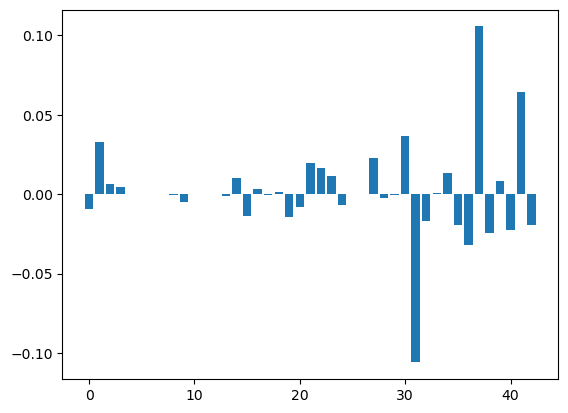

In [66]:
# View which coeficients and their weight
importance = lm_model.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f, column: %s' % (i,v, columns_keep[i]))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [67]:
columns_keep.remove("amenity_Washer")
columns_keep.remove("amenity_Dryer")

In [68]:
# View that average ability to predict goes up with fewer X columns
rsquareds = []
for holiday in list_fed_hols:
    X = clean_s_list[columns_keep]
    y = s_list[holiday]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 
    y_test_preds = lm_model.predict(X_test) 
    rsquared_score = r2_score(y_test, y_test_preds)
    print(holiday, rsquared_score)
    rsquareds.append(rsquared_score)
print("average: " + str(sum(rsquareds)/len(list_fed_hols)))

Martin Luther King Day 0.7153220821686934
Presidents Day 0.8223012818224242
Memorial Day 0.6875968936543015
Independence Day 0.8068261062082764
Labor Day 0.8603110361257333
Columbus Day 0.8482466016876087
Veterans Day 0.8207889809538123
Thanksgiving 0.812611535123704
Thanksgiving observed 0.8113521934983083
Christmas Day 0.7543266920645895
Christmas Day observed 0.7542455693563435
New Years Day 0.670039218590453
average: 0.7803306826045207


Feature: 0, Score: -0.00901, column: accommodates
Feature: 1, Score: 0.03316, column: bathrooms
Feature: 2, Score: 0.00568, column: bedrooms
Feature: 3, Score: 0.00453, column: beds
Feature: 4, Score: -0.00009, column: price
Feature: 5, Score: 0.00002, column: weekly_price
Feature: 6, Score: 0.00000, column: monthly_price
Feature: 7, Score: 0.00001, column: security_deposit
Feature: 8, Score: -0.00020, column: cleaning_fee
Feature: 9, Score: -0.00443, column: guests_included
Feature: 10, Score: -0.00004, column: extra_people
Feature: 11, Score: 0.00001, column: minimum_nights
Feature: 12, Score: 0.00000, column: maximum_nights
Feature: 13, Score: -0.00096, column: availability_30
Feature: 14, Score: 0.01005, column: availability_60
Feature: 15, Score: -0.01371, column: availability_90
Feature: 16, Score: 0.00342, column: availability_365
Feature: 17, Score: -0.00049, column: number_of_reviews
Feature: 18, Score: 0.00168, column: review_scores_rating
Feature: 19, Score: -0.01381, column

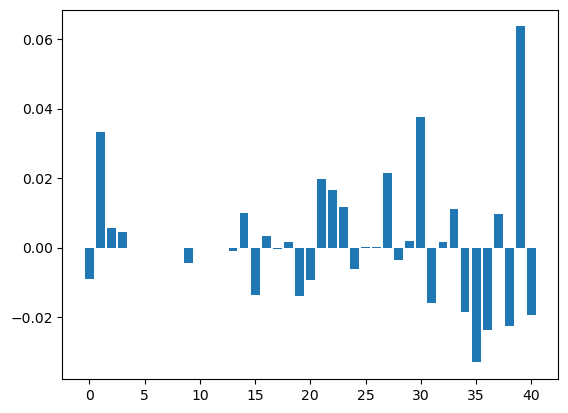

In [69]:
importance = lm_model.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f, column: %s' % (i,v, columns_keep[i]))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [70]:
columns_remove = []
for i in range(len(importance)):
    if importance[i] < .001:
        columns_remove.append(columns_keep[i])
for column in columns_remove:
    columns_keep.remove(column)

In [71]:
# View that average ability to predict goes up with fewer X columns
rsquareds = []
for holiday in list_fed_hols:
    X = clean_s_list[columns_keep]
    y = s_list[holiday]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 
    y_test_preds = lm_model.predict(X_test) 
    rsquared_score = r2_score(y_test, y_test_preds)
    print(holiday, rsquared_score)
    rsquareds.append(rsquared_score)
print("average: " + str(sum(rsquareds)/len(list_fed_hols)))

Martin Luther King Day 0.6193040096706297
Presidents Day 0.692369138024522
Memorial Day 0.6662211233330949
Independence Day 0.8059109941066089
Labor Day 0.8394161646171423
Columbus Day 0.8118108786515696
Veterans Day 0.7751211559577116
Thanksgiving 0.7634989145970918
Thanksgiving observed 0.7614376271027826
Christmas Day 0.6865839803761302
Christmas Day observed 0.6862521065576185
New Years Day 0.598164303629167
average: 0.7255075330520057


Feature: 0, Score: 0.03389, column: bathrooms
Feature: 1, Score: 0.00865, column: bedrooms
Feature: 2, Score: -0.01057, column: beds
Feature: 3, Score: -0.00905, column: availability_60
Feature: 4, Score: 0.00310, column: availability_365
Feature: 5, Score: -0.00071, column: review_scores_rating
Feature: 6, Score: 0.00214, column: review_scores_checkin
Feature: 7, Score: 0.02735, column: review_scores_communication
Feature: 8, Score: 0.01166, column: review_scores_location
Feature: 9, Score: -0.02515, column: amenity_Wireless Internet
Feature: 10, Score: -0.03594, column: amenity_Heating
Feature: 11, Score: 0.02478, column: amenity_TV
Feature: 12, Score: -0.02454, column: amenity_Shampoo
Feature: 13, Score: 0.01250, column: amenity_Kitchen
Feature: 14, Score: -0.00612, column: host_location_Seattle, Washington, United States
Feature: 15, Score: 0.07987, column: host_has_profile_pic_t


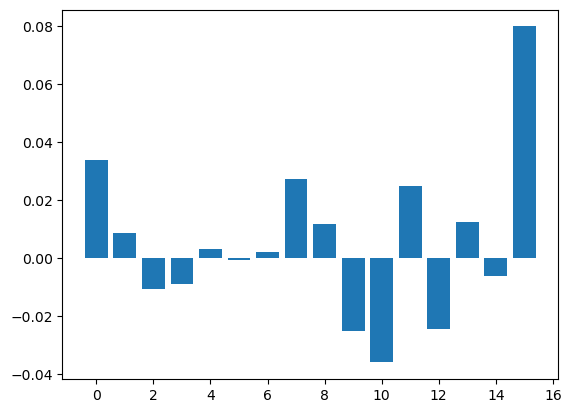

In [72]:
importance = lm_model.coef_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f, column: %s' % (i,v, columns_keep[i]))
plt.bar([x for x in range(len(importance))], importance)
plt.show()